The amount of hydrogen atoms is 45.2690334 moles
The amount of carbon atoms is 11.163403345 moles
The amount of oxygen atoms is 14.381303345 moles


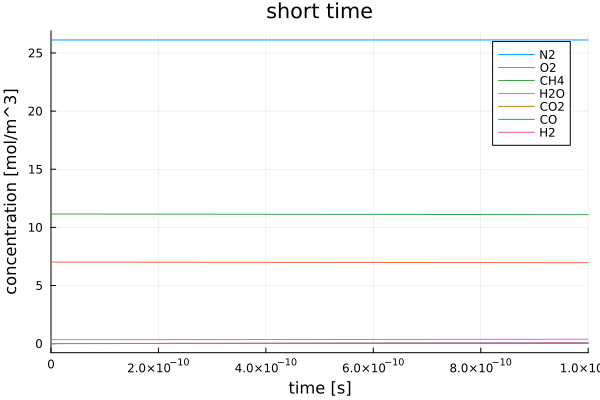

The amount of hydrogen atoms is 45.269033400000005 moles
The amount of carbon atoms is 11.163403345 moles
The amount of oxygen atoms is 14.381303345000013 moles


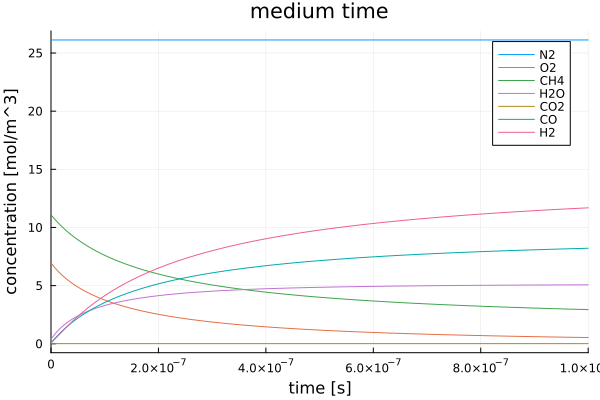

The amount of hydrogen atoms is 45.26903340000005 moles
The amount of carbon atoms is 11.163403345000015 moles
The amount of oxygen atoms is 14.381303345000006 moles


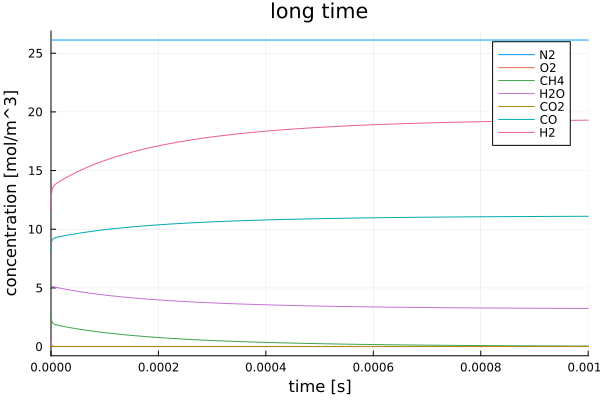

The amount of hydrogen atoms is 45.269033400000176 moles
The amount of carbon atoms is 11.163403345000026 moles
The amount of oxygen atoms is 14.381303345000028 moles


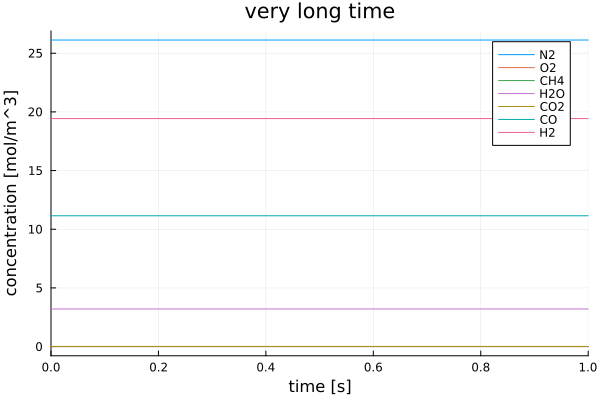

The amount of hydrogen atoms is 45.26903340000021 moles
The amount of carbon atoms is 11.163403345000035 moles
The amount of oxygen atoms is 14.381303345000036 moles


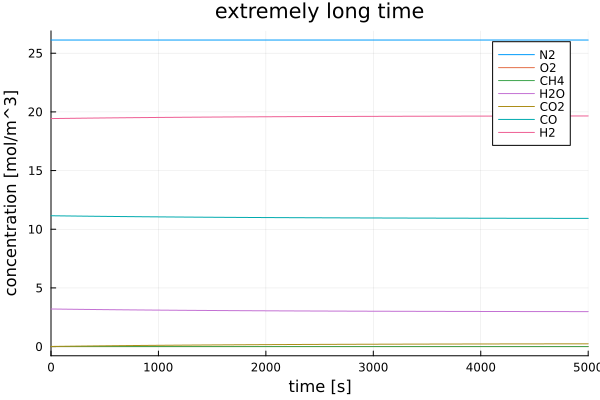

The amount of hydrogen atoms is 45.26903340000017 moles
The amount of carbon atoms is 11.163403345000036 moles
The amount of oxygen atoms is 14.381303345000035 moles


In [12]:
using DifferentialEquations
using Plots
using LinearAlgebra

# Temperature (assumed constant)
T = 1200 # K

# Initial species concentrations: N2, O2, CH4, H2O, CO2, CO, H2
X0 = [26.12, 7.01, 11.15, 0.3345, 0.0134, 0.000003345, 0.0000167] # mol/m^3, 75% air 25% methane mixture at 1 bar

# Atomic accounting check
println("The amount of hydrogen atoms is "*string(X0[3]*4+X0[4]*2+X0[7]*2)*" moles")
println("The amount of carbon atoms is "*string(X0[3]+X0[5]+X0[6])*" moles")
println("The amount of oxygen atoms is "*string(X0[2]*2+X0[4]+X0[5]*2+X0[6])*" moles")


# Stoichiometric matrix
S = [0 -0.5 -1 0 0 1 2; 
     0 0 -1 -1 0 1 3; 
     0 -0.5 0 1 0 0 -1; 
     0 0.5 0 -1 0 0 1; 
     0 0 0 -1 1 -1 1; 
     0 0 0 1 -1 1 -1]

# Reaction rate function
function Arrhenius(T, X)
    R = 1.987204258640
    k  = zeros(6)
    k[1] = 0.44e12 * exp(-30000 / (R * T)) #from Jones & Lindstedt 1988
    k[2] = 0.30e9 * exp(-30000 / (R * T)) #from Jones & Lindstedt 1988
    k[3] = 0.25e17 * T^-1 * exp(-40000 / (R * T)) #from Jones & Lindstedt 1988
    k[4] = 0
    k[5] = 5.0e12 * exp(-67300/ (R * T)) #from Graven & Long 1953
    k[6] = 9.5e10 * exp(-57000/ (R * T)) #from Graven & Long 1953

    # Ensure non-negative concentrations
    Y = max.(X, 0)  # Avoid zero or negative concentrations for stability

    # Reaction rates
    r = zeros(6)
    r[1] = k[1] * Y[3]^0.5 * Y[2]^1.25 #from Jones & Lindstedt 1988
    r[2] = k[2] * Y[3] * Y[4] #from Jones & Lindstedt 1988
    r[3] = k[3] * Y[7]^0.5 * Y[2]^2.25 * Y[4]^-1 #from Jones & Lindstedt 1988
    r[4] = 0
    r[5] = k[5] * Y[6]^0.5 * Y[4] / (1 + 1.2e4 * Y[7]) #from Graven & Long 1953
    r[6] = k[6] * Y[7]^0.5 * Y[5] / (1 + 3.6e3 * Y[6]) #from Graven & Long 1953

    return r
end

# Differential equations function
function f!(dX, X, p, t)
    r = Arrhenius(T, X)
    dX .= S'*r
end

# Define and solve problems for different time spans
time_spans = [1e-9, 1e-6, 1e-3, 1, 5000]
titles = ["short time", "medium time", "long time","very long time","extremely long time"]

plots = []

for (tend, title) in zip(time_spans, titles)
    tspan = (0, tend)
    
    # Define ODE problem
    problem = ODEProblem(f!, X0, tspan)
    
    # Solve ODE problem with a stiff solver and tighter tolerances
    sol = solve(problem, alg_hints=[:stiff], reltol=1e-9, abstol=1e-12)

    X0=last(sol.u)

    # Plot solution obtained 
    plt = plot(sol, xlabel = "time [s]", ylabel = "concentration [mol/m^3]", title = title, label = ["N2" "O2" "CH4" "H2O" "CO2" "CO" "H2"])
    display(plt)

    # Atomic accounting check
    println("The amount of hydrogen atoms is "*string(X0[3]*4+X0[4]*2+X0[7]*2)*" moles")
    println("The amount of carbon atoms is "*string(X0[3]+X0[5]+X0[6])*" moles")
    println("The amount of oxygen atoms is "*string(X0[2]*2+X0[4]+X0[5]*2+X0[6])*" moles")
end
